# Labeled Component Unfolding (LCU)

O algoritmo LCU é um sistema dinâmico que pode ser aplicado numa rede complexa para resolver problemas semi-supervisionados. Seu funcionamento espelha-se em comportamentos da natureza e sistemas sociais, como sobrevivência, competição por recursos, exploração territorial e campanhas de eleição.

O autor desse algoritmo é brasileiro, Dr. Filipe Verri (ITA), sendo publicado como um artigo no IEEE (2016) e componente da sua tese de doutorado *Collective dynamics in complex networks for machine learning* (2018).

Diferentes de modelos de machine learning mais conhecidos, indutivos, onde há uma etapa prévia de aprendizado e então outra de predição, este algoritmo é classificado **transdutivo**: o aprendizado ocorre de maneira indireta enquanto a predição é feita! Ocorre uma etapa única, iterativa, de classificação.

Nessa camada de resolução do problema de segmentação de imagem, já precisamos ter uma rede complexa formada, neste caso através de superpixels e extração de características para calcular o peso das arestas.

In [2]:
from egsis import EGSIS
from egsis import LCU

In [19]:
import random
import networkx as nx

G = nx.dorogovtsev_goltsev_mendes_graph(4)
node_mark_red = [0, 5, 3, 4]
labels = {
    0: 2,
    5: 2,
    3: 1,
    4: 1
}
class_by_color = {
    1: "#00ffff",
    2: "#ff0000"
}
default = "#aaaaaa"
color_map = [class_by_color.get(labels.get(node), default)
             for node in G.nodes]
for node, label in labels.items():
    G.nodes[node]["label"] = label
    
for edge in G.edges:
    G.edges[edge]["weight"] = 1

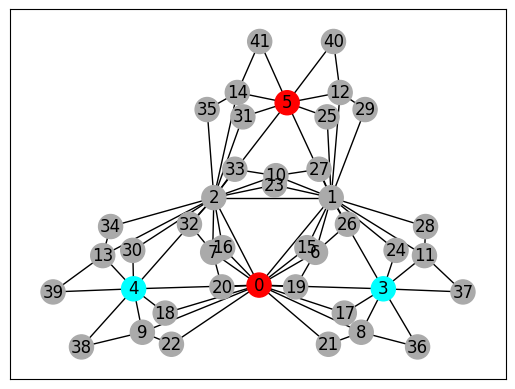

In [20]:
nx.draw_networkx(G, node_color=color_map, pos=nx.spectral_layout(G))

In [21]:
lcu = LCU(n_classes=2)

In [22]:
sub_networks = lcu.fit_predict(G)

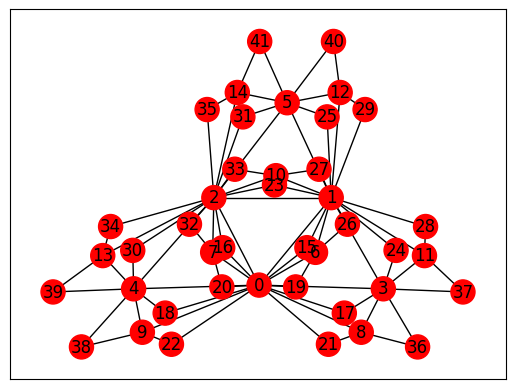

In [29]:
Gn = nx.compose(sub_networks[0], sub_networks[1])
labels = {}
for label in [1, 2]:
    for node in sub_networks[label - 1].nodes:
            labels[node] = label

color_map = [class_by_color[labels[node]] for node in Gn.nodes]

nx.draw_networkx(Gn, node_color=color_map, pos=nx.spectral_layout(Gn))

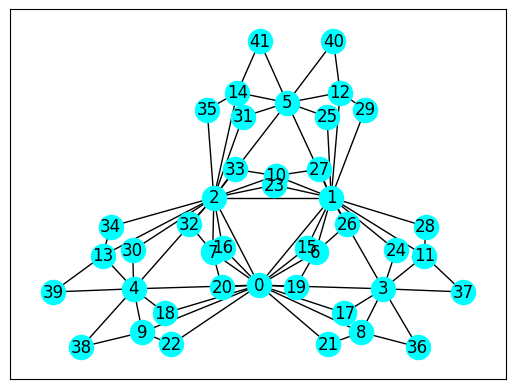

In [34]:
g = sub_networks[1]
nx.draw_networkx(g, node_color=class_by_color[1], pos=nx.spectral_layout(g))

In [35]:
{1, 2, 3} ^ {3, 2, 1}

set()